# Calculate GSFE

### This script will use mdapy to calculate the generalized stacking fault energy directly

In [1]:
import mdapy as mp
import polars as pl
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from mdapy import set_figure
mp.init()

[Taichi] version 1.7.1, llvm 15.0.1, commit 0f143b2f, win, python 3.10.13
[Taichi] Starting on arch=x64


In [2]:
mp.__version__

'0.10.9'

### Generate a FCC lattice with orientation x[11-2], y[1-10] and z[111]

In [3]:
lattice_constant = 4.05
lattice_type = 'FCC'

In [4]:
fcc = mp.LatticeMaker(lattice_constant, lattice_type, 10, 15, 10, crystalline_orientation=np.array([[1, 1, -2], [1, -1, 0], [1, 1, 1]]))
fcc.compute()

In [5]:
system = mp.System(pos=fcc.pos, box=fcc.box)

### Change boundary condition to free along z axis

In [6]:
system.boundary[-1] = 0

### Calculate the initial potential energy

In [7]:
potential = mp.EAM('../../../example/Al_DFT.eam.alloy')

In [8]:
energy, _, _ = system.cal_energy_force_virial(potential, ['Al'])

In [9]:
pe0 = energy.sum()

In [10]:
move = (lattice_constant/6**0.5+0.2)/50
factor = system.box[0,0]* system.box[1,1]/16021.766200000002

### Calculate the GSFE along [112] direction

In [11]:
sfe = [0.]
for i in tqdm(range(1, 51)):
    newdata = system.data.with_columns(pl.when(pl.col('z')>35).then(pl.col('x')+move).otherwise(pl.col('x')).alias('x'))
    system.update_data(newdata,update_pos=True) # Move the upper part.
    system.wrap_pos() # Wrap the positions
    system.if_neigh = False # Make sure rebuild neighbor every time
    energy, _, _ = system.cal_energy_force_virial(potential, ['Al'])
    sfe.append((energy.sum()-pe0)/factor)

100%|██████████| 50/50 [00:04<00:00, 10.98it/s]


### Plot the results

Text(0.97, 25, 'ISF')

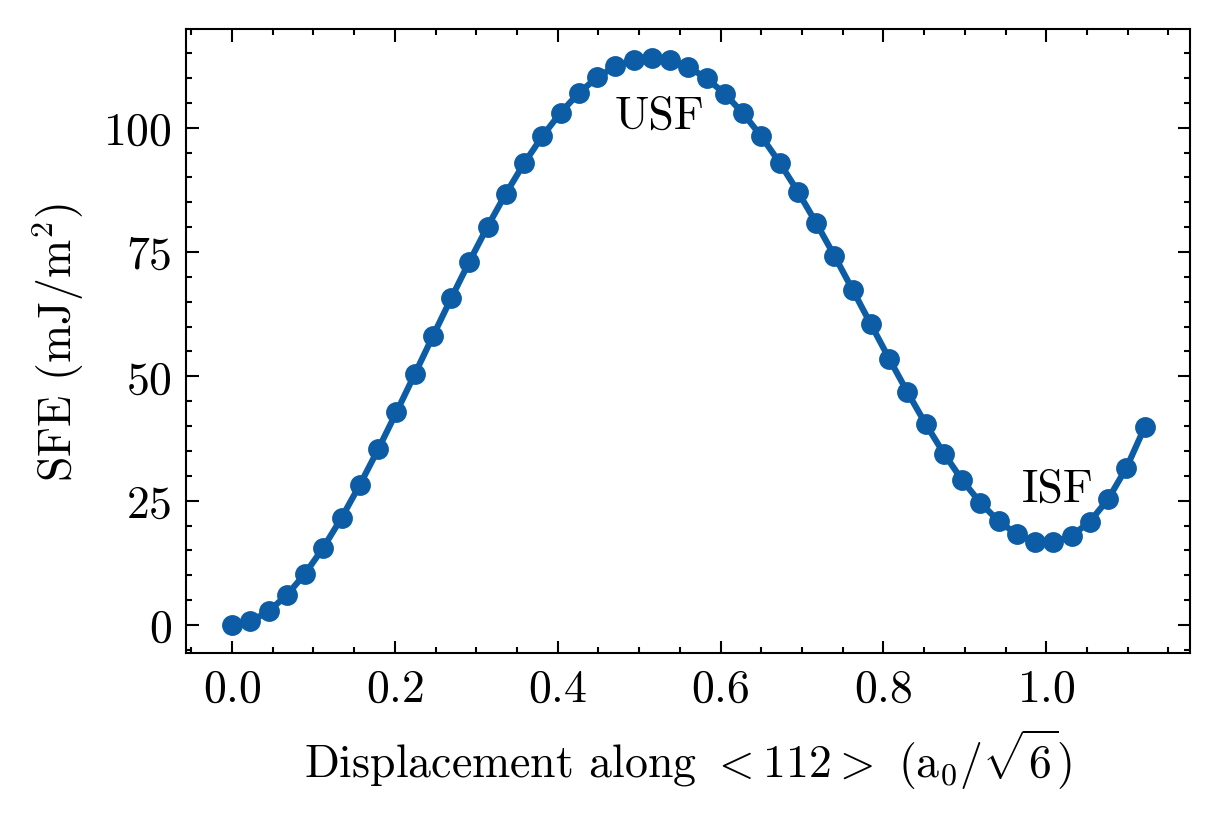

In [12]:
fig, ax = set_figure(figsize=(10, 7), use_pltset=True)

plt.plot(np.arange(51)*move/(lattice_constant/6**0.5), sfe, 'o-')
plt.xlabel("Displacement along $<112>$ " + "$\mathregular{(a_0/\sqrt{6})}$")
plt.ylabel("SFE ($\mathregular{mJ/{m^2}}$)")
plt.text(0.47, 100, 'USF')
plt.text(0.97, 25, 'ISF')